In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import re

In [2]:
file_path = "Life Expectancy Data.csv"
df_life_exp = pd.read_csv(file_path)

In [3]:
df_life_exp.info()
df_life_exp.head()
df_life_exp.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


The column names are all wrong. Let's fix that.

In [4]:
new_col_names = {}
for col_name in df_life_exp.columns:
    # Strip the name from extra white space and switch to lower case
    new_col_names[col_name] = re.sub(' +', ' ',col_name.strip().lower())
    # Display the change in name
    print("'"+col_name+"'", '->', "'"+new_col_names[col_name]+"'")
# Rename the columns into a new data frame
df_life_exp_renamed = df_life_exp.rename(columns=new_col_names)

'Country' -> 'country'
'Year' -> 'year'
'Status' -> 'status'
'Life expectancy ' -> 'life expectancy'
'Adult Mortality' -> 'adult mortality'
'infant deaths' -> 'infant deaths'
'Alcohol' -> 'alcohol'
'percentage expenditure' -> 'percentage expenditure'
'Hepatitis B' -> 'hepatitis b'
'Measles ' -> 'measles'
' BMI ' -> 'bmi'
'under-five deaths ' -> 'under-five deaths'
'Polio' -> 'polio'
'Total expenditure' -> 'total expenditure'
'Diphtheria ' -> 'diphtheria'
' HIV/AIDS' -> 'hiv/aids'
'GDP' -> 'gdp'
'Population' -> 'population'
' thinness  1-19 years' -> 'thinness 1-19 years'
' thinness 5-9 years' -> 'thinness 5-9 years'
'Income composition of resources' -> 'income composition of resources'
'Schooling' -> 'schooling'


Infant deaths and under-five deaths look similar. Let's check that

In [5]:
df_diff = df_life_exp_renamed['under-five deaths'] - df_life_exp_renamed['infant deaths']
df_diff = df_diff[df_diff != 0]
df_diff.max(), df_diff.min(), np.abs(df_diff).sum(), len(df_diff)

(700, 1, 34468, 1627)

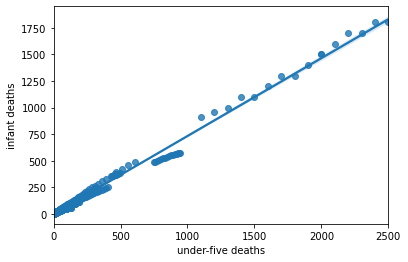

In [6]:
sns.regplot(x=df_life_exp_renamed['under-five deaths'], y=df_life_exp_renamed['infant deaths'])

Since there is a very high correlation and infant deaths is included in under-five deaths, so we drop infant deaths as it doesn't add new information.

In [7]:
df_life_exp_renamed.drop('infant deaths', axis=1, inplace=True)
df_life_exp_renamed.describe()

,year,life expectancy,adult mortality,alcohol,percentage expenditure,hepatitis b,measles,bmi,under-five deaths,polio,total expenditure,diphtheria,hiv/aids,gdp,population,thinness 1-19 years,thinness 5-9 years,income composition of resources,schooling
count,2938.000000,2928.000000,2928.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


There are some missing data points, so we explore how much of the data is missing.

In [8]:
# Calculate percentage of missing data
percent_missing = df_life_exp_renamed.isna().sum() * 100 / len(df_life_exp_renamed)
data = zip(df_life_exp_renamed.columns, percent_missing, df_life_exp_renamed.dtypes)
# Create data frame with missing data numbers
df_missing = pd.DataFrame(data=data, columns=['column name', '% missing', 'dtype'])
# Check columns with missing data
df_missing = df_missing[df_missing['% missing'] > 0]
df_missing

,column name,% missing,dtype
3,life expectancy,0.340368,float64
4,adult mortality,0.340368,float64
5,alcohol,6.603131,float64
7,hepatitis b,18.822328,float64
9,bmi,1.157250,float64
11,polio,0.646698,float64
12,total expenditure,7.692308,float64
13,diphtheria,0.646698,float64
15,gdp,15.248468,float64
16,population,22.191967,float64


Knowing that there's lots of missing data, we need to impute the missing data as follows:
1. Check the distribution of the missing columns.
1. Impute the missing values with a function that's appropriate to the distribution.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

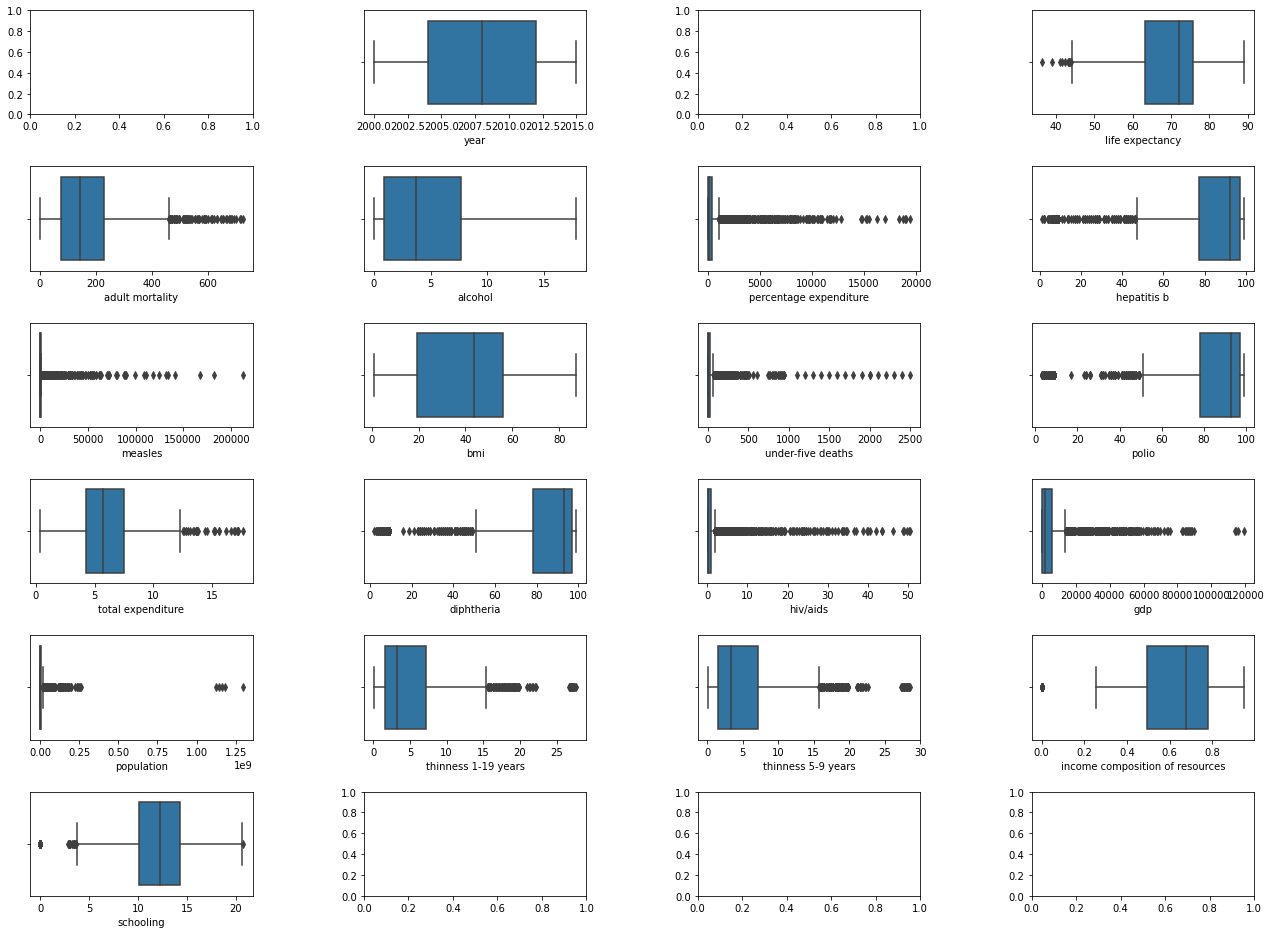

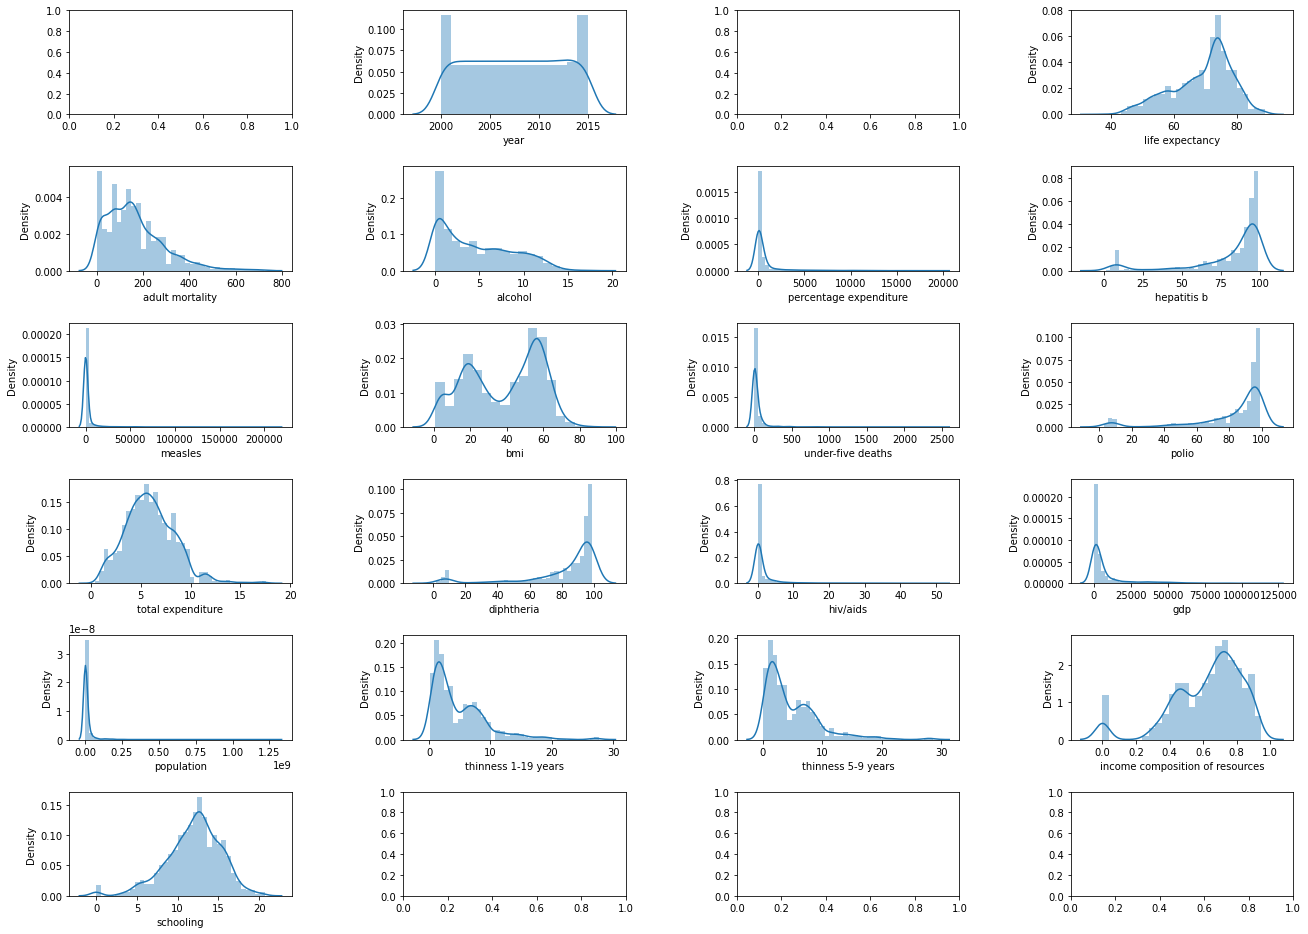

In [9]:
def plot(df, plotting_func, n_cols=4, n_rows=None, figsize=(20, 15)):
    assert (n_cols is None) ^ (n_rows is None), 'Define only one of n_rows or n_cols'
    # Get columns
    columns = df.columns
    # Derive the other dimension
    if n_rows != None:
        n_cols = math.ceil(len(columns) / n_rows)
    else:
        n_rows = math.ceil(len(columns) / n_cols)
    axes = plt.subplots(n_rows, n_cols, figsize=figsize)[1]
    for row in range(n_rows):    
        for col in range(n_cols):
            index = row * n_cols + col
            if index >= len(columns):
                break
            # Skip columns with non-numeric values
            if not pd.api.types.is_numeric_dtype(df[columns[index]]):
                continue
            plotting_func(df[columns[index]], ax=axes[row, col])
    plt.subplots_adjust(top=0.92, bottom=0.1, left=0.10, right=0.95, hspace=0.5, wspace=0.5)


# Check the distribution of the columns using box plots
plot(df_life_exp_renamed, sns.boxplot)
# Check the ditribution of the columns using dist plot (bar plots)
plot(df_life_exp_renamed, sns.distplot)

In [10]:
df_life_exp_renamed.head()

,country,year,status,life expectancy,adult mortality,alcohol,percentage expenditure,hepatitis b,measles,bmi,under-five deaths,polio,total expenditure,diphtheria,hiv/aids,gdp,population,thinness 1-19 years,thinness 5-9 years,income composition of resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Since there are some outliers, we impute using the median.

In [11]:
df_life_exp_imputed = df_life_exp_renamed.copy()
df_life_exp_imputed.fillna((df_life_exp_imputed.median(axis=0)), inplace=True)

Now let's take a look at the correlation between columns

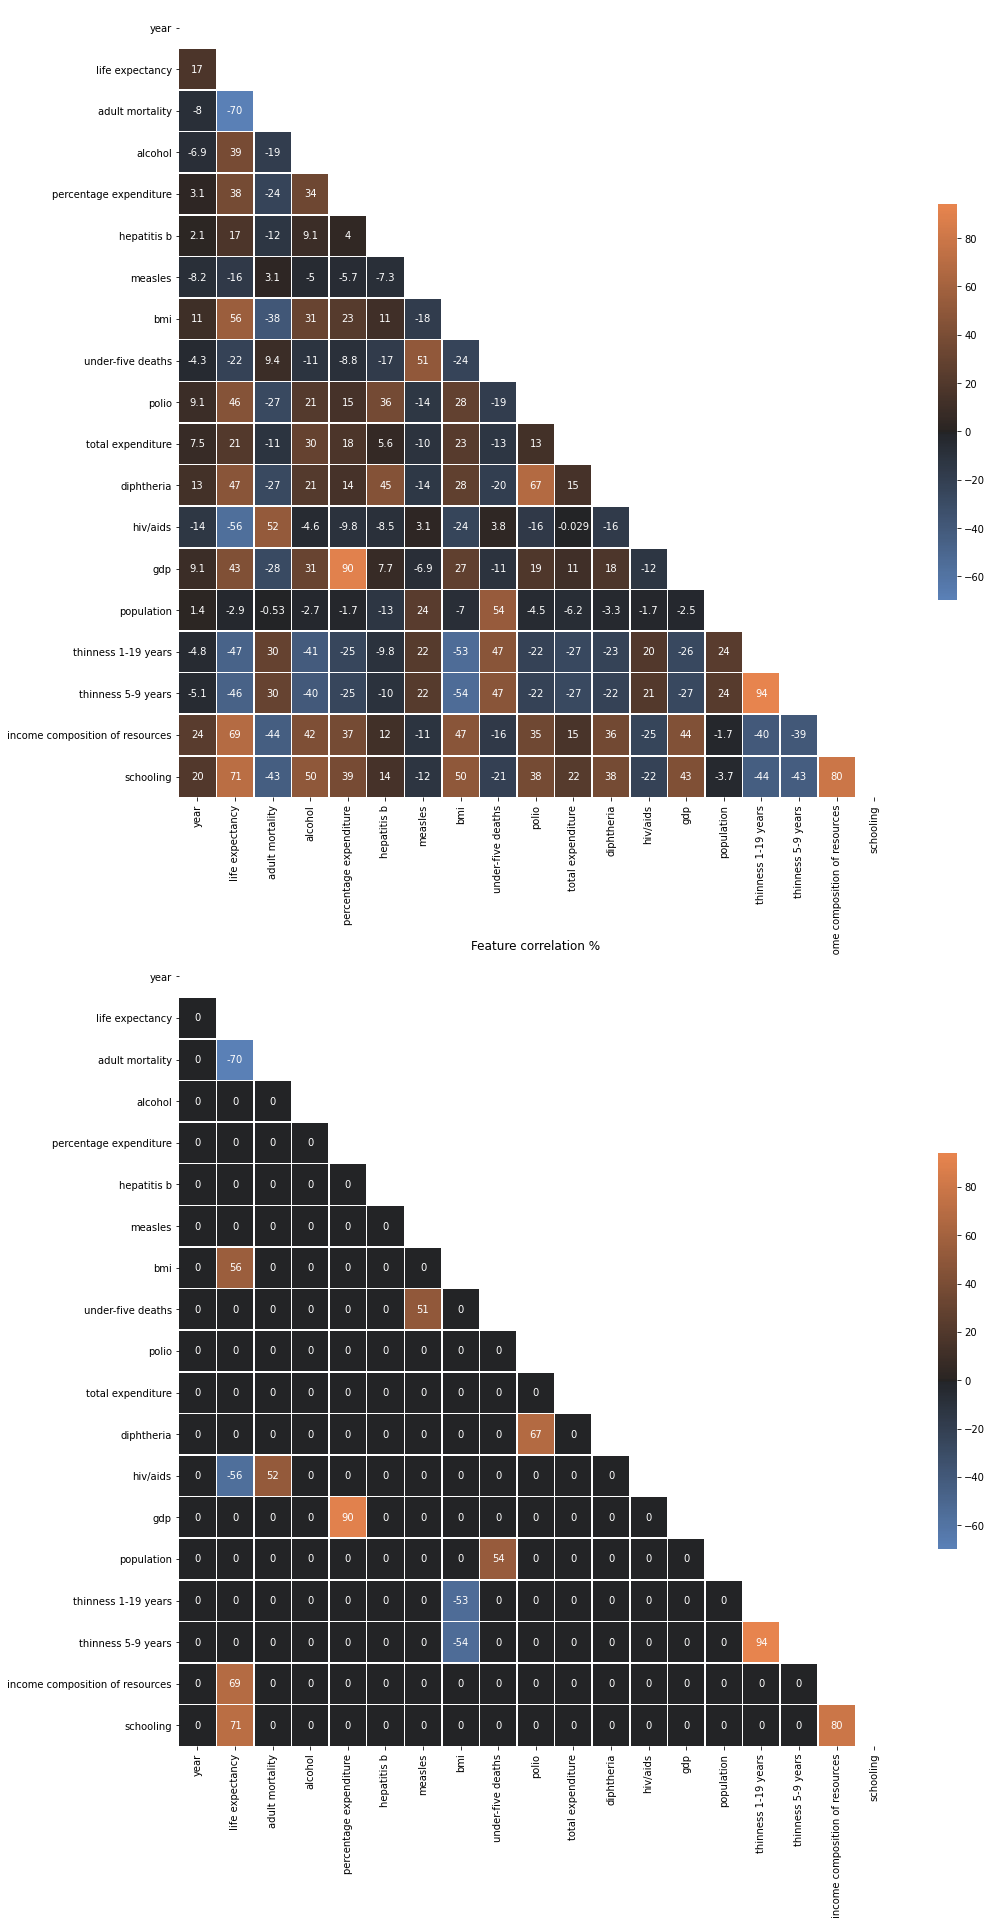

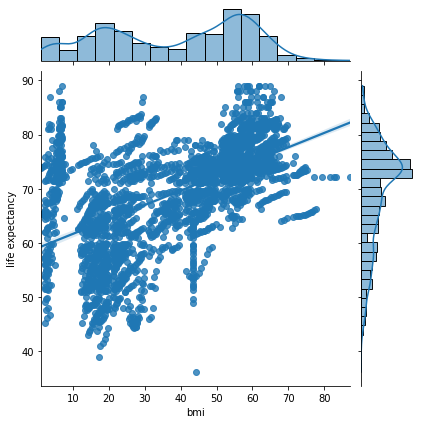

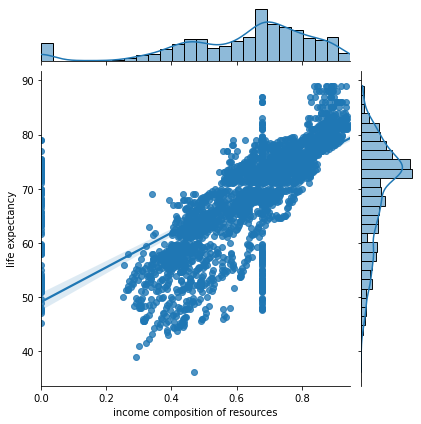

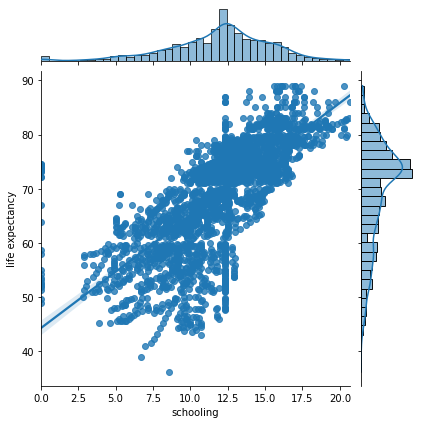

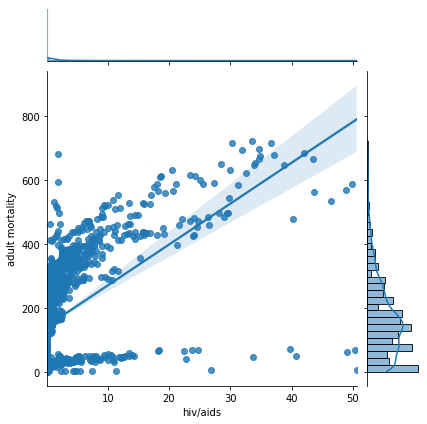

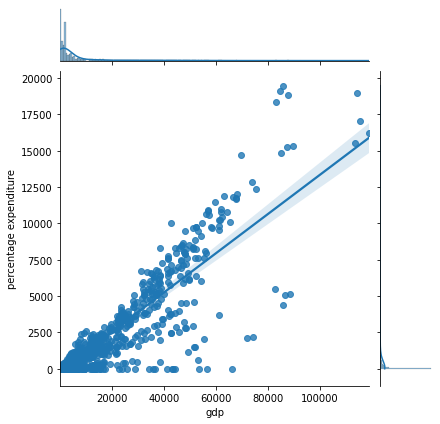

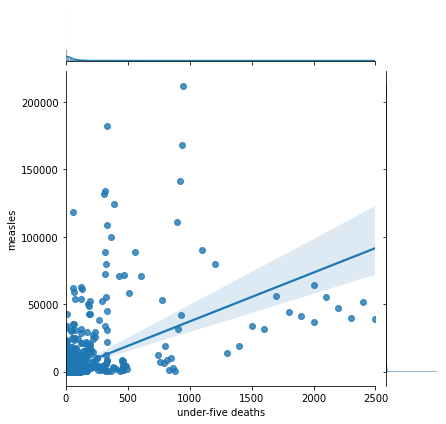

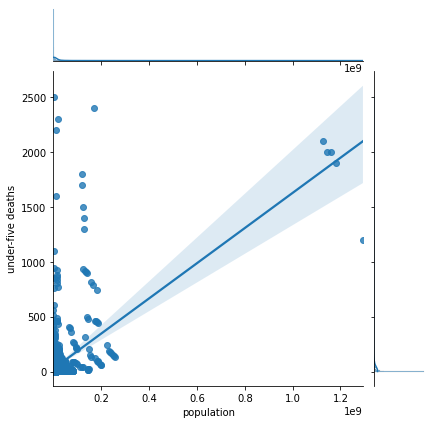

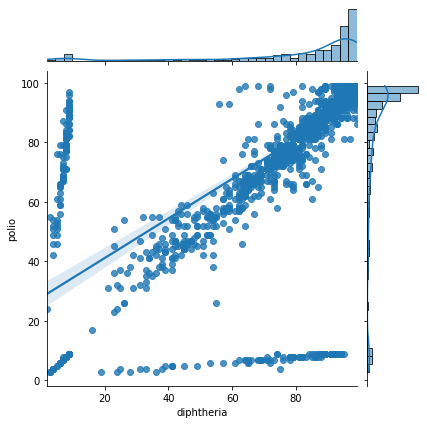

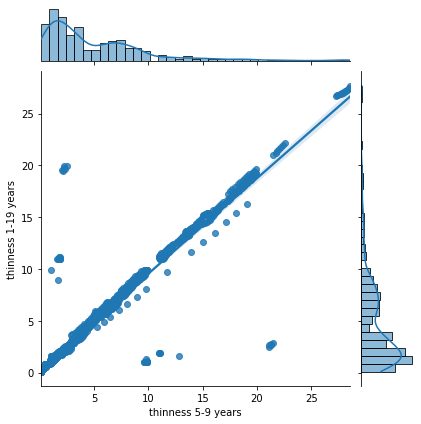

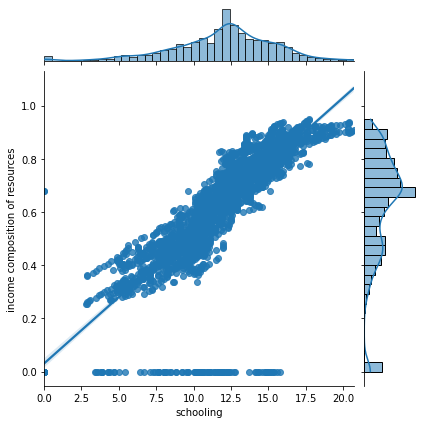

In [12]:
# Let's take a look at the correlation matrix
def plot_correlation_matrix(df, title=None, cutoff=50):
    # Computer correlation matrix
    corr_full = df.corr() * 100
    corr_cut = corr_full.copy()
    corr_cut[~((corr_cut <= -cutoff) | (corr_cut >= cutoff))] = 0
    axs = plt.subplots(2, 1, figsize=(16, 32))[1]
    for (corr, ax) in zip([corr_full, corr_cut], axs):
        # Generate mask for the upper triangle
        mask = np.triu(np.ones_like(corr, dtype=bool))
        # Set up figure
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
        # Draw the heatmap with the mask and corrent aspect ratio
        sns.heatmap(corr, mask=mask, center=0.0, cmap=cmap, linewidths=.5, cbar_kws={'shrink':.5}, annot=True, ax=ax)
        if title:
            plt.title(title)
    corr_cut[mask] = 0
    # Return the cutoff mask
    return corr_cut


cutoff = 50
corr_cut = plot_correlation_matrix(df_life_exp_imputed, 'Feature correlation %', cutoff)
# Lets check the joint plots of correlated data above the cutoff
corr_cut = corr_cut[corr_cut > 0.0].reset_index()
corr_cut = corr_cut.melt(id_vars='index', value_name='corr', var_name='x2')
corr_cut = corr_cut[corr_cut['corr'].notna()]
for x1, x2, _ in corr_cut.values:
    sns.jointplot(x=x1, y=x2, data=df_life_exp_imputed, kind='reg')

##Feature Engineering

In [13]:
df_life_exp_imputed.columns

Index(['country', 'year', 'status', 'life expectancy', 'adult mortality',
       'alcohol', 'percentage expenditure', 'hepatitis b', 'measles', 'bmi',
       'under-five deaths', 'polio', 'total expenditure', 'diphtheria',
       'hiv/aids', 'gdp', 'population', 'thinness 1-19 years',
       'thinness 5-9 years', 'income composition of resources', 'schooling'],
      dtype='object')

In [14]:
df_life_exp_imputed.head()

,country,year,status,life expectancy,adult mortality,alcohol,percentage expenditure,hepatitis b,measles,bmi,under-five deaths,polio,total expenditure,diphtheria,hiv/aids,gdp,population,thinness 1-19 years,thinness 5-9 years,income composition of resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
